# 4. Modeling

In [1]:
#Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, mean_absolute_error, make_scorer
from bayes_opt import BayesianOptimization

In [2]:
#Load the data
df = pd.read_csv('Data/processed_Corona_NLP.csv', index_col=0)
df.head()

,OriginalTweet,Sentiment,ProcessedTweet,DocVector,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,...,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24
0,TRENDING: New Yorkers encounter empty supermar...,0,trend new yorkers encounter empty supermarket ...,[ -31.063377 4.315184 3.272048 -18.3...,-31.063377,4.315184,3.272048,-18.336933,20.507353,-18.973701,...,12.867351,36.950283,-19.829515,22.515028,1.602518,-13.314288,-18.912729,-7.682436,-29.146791,-32.590302
1,When I couldn't find hand sanitizer at Fred Me...,3,could not find hand sanitizer fred meyer turn ...,[ -18.462826 11.85384 -2.6134028 6.3...,-18.462826,11.853840,-2.613403,6.349799,-18.324095,-4.529284,...,-1.200512,8.932176,-8.927069,15.534106,-15.571704,-4.428163,11.713925,12.254540,5.701349,-26.367716
2,Find out how you can protect yourself and love...,4,find protect love one,[ -2.7797158 3.3976798 -5.5020814 8.44067...,-2.779716,3.397680,-5.502081,8.440672,-8.699121,-5.226532,...,4.212283,5.015493,-11.010517,5.611660,-7.700294,-2.587625,-0.576298,-5.781661,0.555235,-8.109362
3,#Panic buying hits #NewYork City as anxious sh...,1,buy hit city anxious shopper stock foodampmedi...,[ -40.63399 35.210224 -24.598307 -49.4...,-40.633991,35.210224,-24.598307,-49.416866,8.011915,7.370157,...,6.071897,28.622406,-23.586481,-16.194962,-31.503876,-27.649782,-26.429310,-12.657497,-22.968901,-21.575285
4,#toiletpaper #dunnypaper #coronavirus #coronav...,2,everyone buy baby milk powder next everyone bu...,[ -22.85473 14.65009 17.584171 ...,-22.854731,14.650090,17.584171,6.330812,-3.588906,6.745114,...,-7.855762,31.614111,-41.765991,2.643752,8.316241,-27.605976,-7.106748,15.256669,24.210051,-8.261431


Before we can begin modeling the data, we need to divide the it into explanatory and reponse variables, scale the explanatory variable, and divide each variable into the train and tests sets. 

In [3]:
y = df['Sentiment']
X = df.drop(columns=['OriginalTweet', 'Sentiment', 'ProcessedTweet', 'DocVector'])

In [4]:
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=42)

In following sections, I will use bayesian optimization to tune three simple classifiers (k-nearest neighbors, naive bayes, and decision tree) and two ensemble ones (random forest and ada boosting) on the basis of mean difference in sentiment score (i.e., Mean Absolute Error). MAE makes the most sense as a scoring metric because I'm more concerned with the overall performance of each classifier than its recall or precision (as would be the case with medical diagnostics or spam filters respectively). MAE also measures the severity of errors unlike other holistic metrics such as Matthew's Correlation Coefficient. A classifier that labeled all extremely positive Tweets as extremely negative, for example, would receive the same MCC score as a classifier that simply downgraded all extremely positive Tweets to positive. I will also plot the confusion matrix and distribution of predicted labels for each classifier in order to determine where it struggles. These visualizations along with mean difference in sentiment score will inform the final model selection.

In [6]:
MAE = make_scorer(mean_absolute_error, greater_is_better=False)

## K-Nearest Neighbors

In [70]:
def knn_eval(n_neighbors):
    params = {'n_neighbors' : int(n_neighbors)}
    scores = cross_val_score(KNeighborsClassifier(**params), X_train, y_train, scoring=MAE, cv=5)
    score = scores.mean()
    return score
    
knn_BO = BayesianOptimization(knn_eval, {'n_neighbors' : (1 , 99)})

knn_BO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | n_neig... |
-------------------------------------
|  1        | -0.963    |  79.59    |
|  2        | -0.9585   |  84.63    |
|  3        | -0.9585   |  84.62    |
|  4        | -0.961    |  91.11    |
|  5        | -1.022    |  14.79    |
|  6        | -0.9689   |  51.14    |
|  7        | -0.9664   |  63.13    |
|  8        | -0.9588   |  99.0     |
|  9        | -0.9809   |  38.93    |
|  10       | -0.9592   |  86.86    |
|  11       | -0.9569   |  96.69    |
|  12       | -0.9672   |  70.58    |


In [71]:
best_params_knn = knn_BO.max
best_params_knn

{'target': -0.9569488305009454, 'params': {'n_neighbors': 96.68874973677218}}

In [73]:
knn = KNeighborsClassifier(n_neighbors=int(best_params_knn['params']['n_neighbors']))
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
mean_absolute_error(y_test, knn_y_pred)

0.9635416666666666

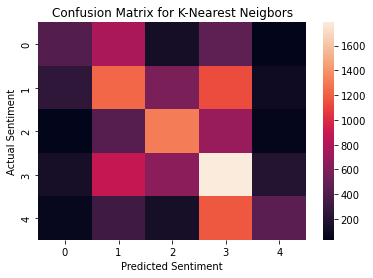

In [74]:
sns.heatmap(confusion_matrix(y_test, knn_y_pred))
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix for K-Nearest Neigbors')
plt.show();

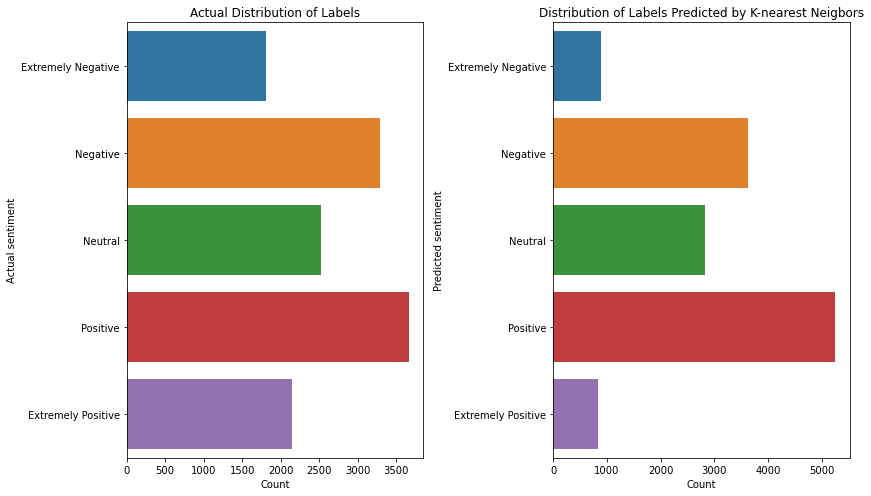

In [75]:
knn_val_counts = pd.DataFrame(np.unique(knn_y_pred, return_counts=True)[1], index=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], columns=['Count'])
actual_counts = pd.DataFrame(np.unique(y_test, return_counts=True)[1], index=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], columns=['Count'])

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 7)
sns.barplot(x='Count', y=actual_counts.index, orient="h", data=actual_counts, ax=ax[0])
ax[0].set_ylabel('Actual sentiment')
ax[0].set_title('Actual Distribution of Labels')
sns.barplot(x='Count', y=knn_val_counts.index, orient="h", data=knn_val_counts, ax=ax[1])
ax[1].set_title('Distribution of Labels Predicted by K-nearest Neigbors')
ax[1].set_ylabel('Predicted sentiment')
fig.tight_layout()
plt.show();

As the heatmap shows, the K-nearest neighbors classifier had the most trouble distinguishing between positive and extremely positive Tweets.  In most cases, it defaulted to Positive, which led to an over-representation of positive labels. More seriously, the KNN classifer also confused positive and negative Tweets fairly regularly. Despite these problems, it still predicted sentiment labels better than I did, achieving a mean difference in sentiment score of .96 to my 1.08. 

## Naive Bayes

In [76]:
def nb_eval(var_smoothing): 
    params = {'var_smoothing' : int(var_smoothing)}
    scores = cross_val_score(GaussianNB(**params), X_train, y_train, scoring=MAE, 
                             cv=5)
    score = scores.mean()
    return score
    
nb_BO = BayesianOptimization(nb_eval, {'var_smoothing' : (10**-9, 1)})

nb_BO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | var_sm... |
-------------------------------------
|  1        | -1.095    |  0.9042   |
|  2        | -1.095    |  0.05993  |
|  3        | -1.095    |  0.9998   |
|  4        | -1.095    |  0.000241 |
|  5        | -1.095    |  1.0      |
|  6        | -1.095    |  0.000206 |
|  7        | -1.095    |  1.0      |
|  8        | -1.095    |  5.353e-0 |
|  9        | -1.095    |  0.9997   |
|  10       | -1.095    |  6.813e-0 |
|  11       | -1.095    |  0.6498   |
|  12       | -1.095    |  0.1928   |


In [77]:
best_params_nb = nb_BO.max
best_params_nb

{'target': -1.0950947266165276,
 'params': {'var_smoothing': 0.9041959382799045}}

In [78]:
nb = GaussianNB(var_smoothing=int(nb_BO.max['params']['var_smoothing']))
nb.fit(X_train, y_train)
nb_y_pred = nb.predict(X_test)
mean_absolute_error(y_test, nb_y_pred)

1.0922619047619047

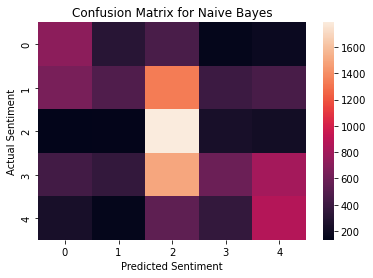

In [79]:
sns.heatmap(confusion_matrix(y_test, nb_y_pred))
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix for Naive Bayes')
plt.show();

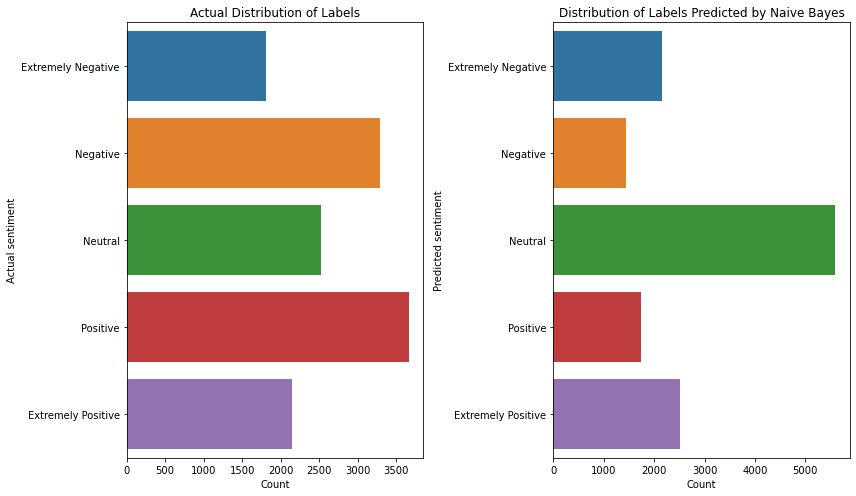

In [80]:
nb_val_counts = pd.DataFrame(np.unique(nb_y_pred, return_counts=True)[1], index=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], columns=['Count'])

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 7)
sns.barplot(x='Count', y=actual_counts.index, orient="h", data=actual_counts, ax=ax[0])
ax[0].set_ylabel('Actual sentiment')
ax[0].set_title('Actual Distribution of Labels')
sns.barplot(x='Count', y=nb_val_counts.index, orient="h", data=nb_val_counts, ax=ax[1])
ax[1].set_title('Distribution of Labels Predicted by Naive Bayes')
ax[1].set_ylabel('Predicted sentiment')
fig.tight_layout()
plt.show();

The Naive Bayes classifier did an excellent job of identifying neutral Tweets, but performed poorly on the other categories. In particular, it frequently missclassified positive and negative Tweets as neutral, which suggests that it defaulted to neutral in the absence of overwhelmingly positive or negative features. The value counts of the predicted labels confirm this assessment with neutral appearing twice as frequently as the next most common label. These problems led the Naive Bayes classifier underperform both me and K-Nearest Neighbors.   

## Decision Tree

In [81]:
def tree_eval(max_depth): 
    params = {'max_depth' : int(max_depth)}
    scores = cross_val_score(DecisionTreeClassifier(**params, random_state=42), X_train, y_train, scoring=MAE, cv=5)
    score = scores.mean()
    return score
    
tree_BO = BayesianOptimization(tree_eval, {'max_depth' : (1, 100)})

tree_BO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | max_depth |
-------------------------------------
|  1        | -1.141    |  2.605    |
|  2        | -1.227    |  71.27    |
|  3        | -1.146    |  1.294    |
|  4        | -1.222    |  20.23    |
|  5        | -1.227    |  100.0    |
|  6        | -1.227    |  45.89    |
|  7        | -1.084    |  9.072    |
|  8        | -1.13     |  12.37    |
|  9        | -1.227    |  85.63    |
|  10       | -1.227    |  58.64    |
|  11       | -1.08     |  7.209    |
|  12       | -1.225    |  33.4     |


In [82]:
best_params_tree = tree_BO.max
best_params_tree

{'target': -1.079628667066412, 'params': {'max_depth': 7.209176161632147}}

In [83]:
tree = DecisionTreeClassifier(max_depth=int(tree_BO.max['params']['max_depth']))
tree.fit(X_train, y_train)
tree_y_pred = tree.predict(X_test)
mean_absolute_error(y_test, tree_y_pred)

1.0805803571428572

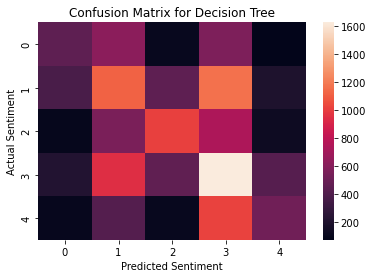

In [84]:
sns.heatmap(confusion_matrix(y_test, tree_y_pred))
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix for Decision Tree')
plt.show();

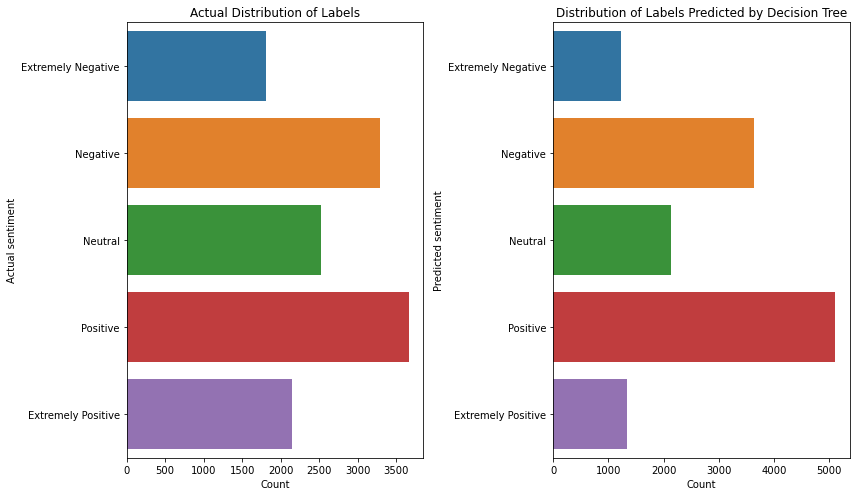

In [85]:
tree_val_counts = pd.DataFrame(np.unique(tree_y_pred, return_counts=True)[1], index=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], columns=['Count'])

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 7)
sns.barplot(x='Count', y=actual_counts.index, orient="h", data=actual_counts, ax=ax[0])
ax[0].set_ylabel('Actual sentiment')
ax[0].set_title('Actual Distribution of Labels')
sns.barplot(x='Count', y=tree_val_counts.index, orient="h", data=tree_val_counts, ax=ax[1])
ax[1].set_title('Distribution of Labels Predicted by Decision Tree')
ax[1].set_ylabel('Predicted sentiment')
fig.tight_layout()
plt.show();

The decision tree classifier suffers from the same problems as the KNN classifier, but to a greater degree. Accordingly, it score worse on mean difference in sentiment.  

## Random Forest

In [7]:
def rf_eval(n_estimators, max_depth, max_features):
    params = {'n_estimators' : int(n_estimators), 'max_depth' : int(max_depth), 'max_features' : int(max_features)}
    scores = cross_val_score(RandomForestClassifier(**params), X_train, y_train, scoring=MAE, cv=5)
    score = scores.mean()
    return score

rf_BO = BayesianOptimization(rf_eval, {'n_estimators' : (200, 2000), 'max_depth' : (10, 100) , 'max_features' : (1, 5)})

rf_BO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        | -0.9204   |  28.06    |  2.912    |  693.0    |
|  2        | -0.9172   |  40.22    |  4.8      |  803.9    |
|  3        | -0.9224   |  41.76    |  4.63     |  805.2    |
|  4        | -0.9467   |  11.23    |  1.75     |  680.2    |
|  5        | -0.9225   |  34.05    |  4.164    |  804.5    |
|  6        | -0.9176   |  37.56    |  3.872    |  797.4    |
|  7        | -0.9203   |  45.59    |  2.366    |  793.3    |
|  8        | -0.9178   |  35.54    |  2.376    |  787.2    |
|  9        | -0.9213   |  42.6     |  4.117    |  781.8    |
|  10       | -0.9192   |  29.13    |  3.025    |  791.8    |
|  11       | -0.9153   |  24.96    |  1.158    |  781.7    |
|  12       | -0.9249   |  32.06    |  1.15     |  780.0    |


In [8]:
best_params_rf = rf_BO.max
best_params_rf

{'target': -0.9153001628812903,
 'params': {'max_depth': 24.964011378647694,
  'max_features': 1.1576578024473956,
  'n_estimators': 781.7223145288478}}

In [9]:
rf = RandomForestClassifier(n_estimators=int(best_params_rf['params']['n_estimators']), max_depth=int(best_params_rf['params']['max_depth']), max_features=int(best_params_rf['params']['max_features']))
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
mean_absolute_error(y_test, rf_y_pred)

0.9265625

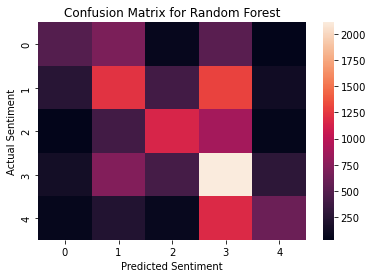

In [15]:
sns.heatmap(confusion_matrix(y_test, rf_y_pred))
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix for Random Forest')
plt.show();

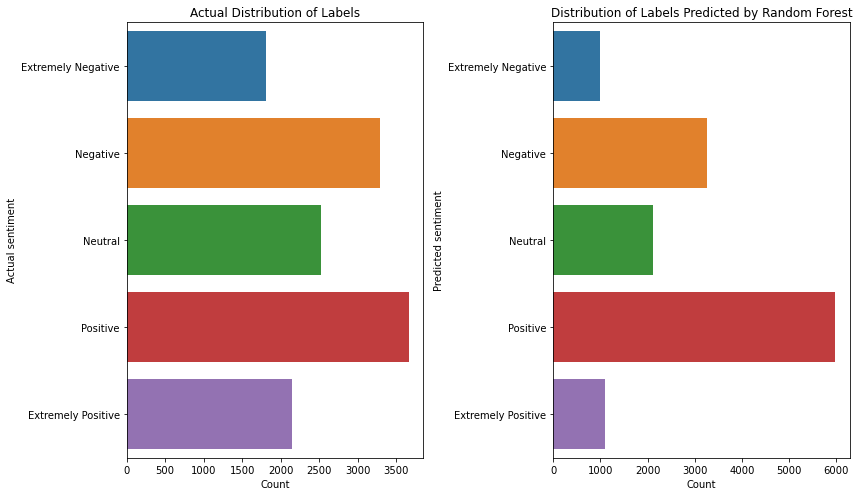

In [19]:
rf_val_counts = pd.DataFrame(np.unique(rf_y_pred, return_counts=True)[1], index=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], columns=['Count'])

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 7)
plot = sns.barplot(x='Count', y=actual_counts.index, orient="h", data=actual_counts, ax=ax[0])
ax[0].set_ylabel('Actual sentiment')
ax[0].set_title('Actual Distribution of Labels')
sns.barplot(x='Count', y=rf_val_counts.index, orient="h", data=rf_val_counts, ax=ax[1])
ax[1].set_title('Distribution of Labels Predicted by Random Forest')
ax[1].set_ylabel('Predicted sentiment')
fig.tight_layout()
plt.show();
fig = plot.get_figure()
fig.savefig("Distribution_comparison")

The Random Forest classifier makes the same kinds of mistakes as the K-Nearest Neighbors and Decision Tree classifiers, but does so to a lesser degree. Unsurprisingly, it is the best classifier so far. 

## Ada Boosting

In [63]:
def ada_eval(n_estimators, learning_rate):
    params = {'n_estimators' : int(n_estimators), 'learning_rate' : int(learning_rate)}
    scores = cross_val_score(AdaBoostClassifier(base_estimator=tree, **params, random_state=42), X_train, y_train, scoring=MAE, cv=5)
    score = scores.mean()
    return score

ada_BO = BayesianOptimization(ada_eval, {'n_estimators' : (200, 2000), 'learning_rate' : (1, 2)})

ada_BO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
|  1        | -1.017    |  1.905    |  592.0    |
|  2        | -1.001    |  1.695    |  796.5    |
|  3        | -1.001    |  1.827    |  795.2    |
|  4        | -0.9645   |  1.055    |  1.995e+0 |
|  5        | -0.9642   |  1.602    |  1.854e+0 |
|  6        | -0.9771   |  1.463    |  1.594e+0 |
|  7        | -0.9783   |  1.891    |  1.311e+0 |
|  8        | -1.149    |  2.0      |  200.0    |
|  9        | -1.031    |  2.0      |  1.132e+0 |
|  10       | -0.9775   |  1.0      |  1.445e+0 |
|  11       | -0.9707   |  1.0      |  1.741e+0 |
|  12       | -0.9639   |  1.992    |  1.93e+03 |


In [64]:
best_params_ada = ada_BO.max
best_params_ada

{'target': -0.9638687937102765,
 'params': {'learning_rate': 1.9922946412050149,
  'n_estimators': 1930.458664805869}}

In [66]:
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=int(best_params_ada['params']['n_estimators']), learning_rate=int(best_params_ada['params']['learning_rate']), random_state=42)
ada.fit(X_train, y_train)
ada_y_pred = ada.predict(X_test)
mean_absolute_error(y_test, ada_y_pred)

0.9635416666666666

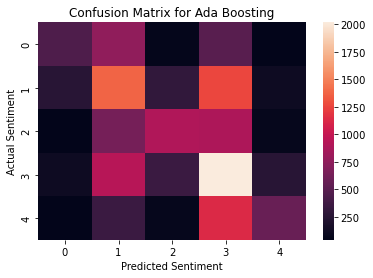

In [68]:
sns.heatmap(confusion_matrix(y_test, ada_y_pred))
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix for Ada Boosting')
plt.show();

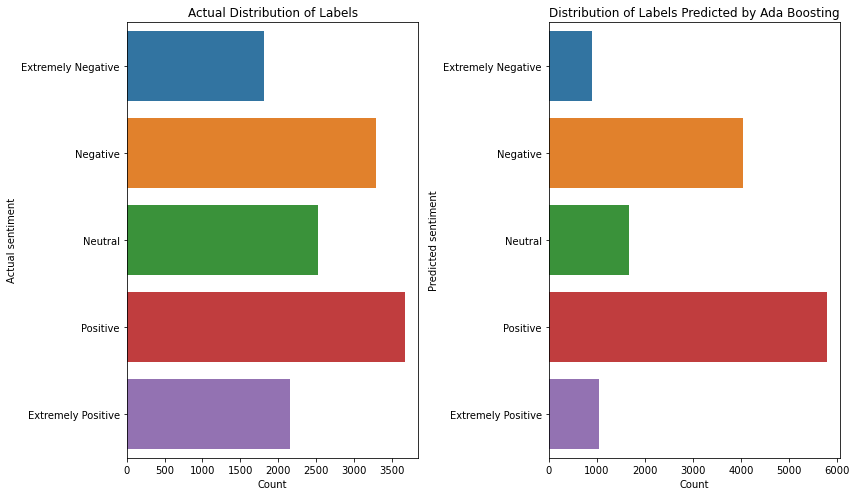

In [69]:
ada_val_counts = pd.DataFrame(np.unique(ada_y_pred, return_counts=True)[1], index=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], columns=['Count'])

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 7)
sns.barplot(x='Count', y=actual_counts.index, orient="h", data=actual_counts, ax=ax[0])
ax[0].set_ylabel('Actual sentiment')
ax[0].set_title('Actual Distribution of Labels')
sns.barplot(x='Count', y=ada_val_counts.index, orient="h", data=ada_val_counts, ax=ax[1])
ax[1].set_title('Distribution of Labels Predicted by Ada Boosting')
ax[1].set_ylabel('Predicted sentiment')
fig.tight_layout()
plt.show();
plt.show();

Ada Boosting improved on the performance of the Decision Tree classifier--achieving a MAE of .96--but did not outperform the Random Forest Classifier. Like KNN and the other tree-based classifiers, it frequently demoted Extremely Positive Tweets to the Positive category and occassionally mixed up Positive and Negative Tweets.

## Conclusion

The best model was the Random Forest classifier with 782 estimators, a maximum of 1 feature, and a max depth of 25. 